In [1]:
from alphazero.coach import Coach
from alphazero.gomoku_game import GomokuGame as Game
from alphazero.interfaces import TrainParams
from domoku.policies.maximal_criticality import MaxCriticalityPolicy
from domoku.policies.softadvice import MaxInfluencePolicy, MaxInfluencePolicyParams, NeuralNetAdapter
from domoku.constants import *

In [2]:
def given_heuristic_brain():
    hard_policy = MaxCriticalityPolicy(board_size=BOARD_SIZE, overconfidence=5.0)
    params = MaxInfluencePolicyParams(
        board_size=BOARD_SIZE,
        sigma=.6,
        iota=6,
        radial_constr=[.0625, .125, .25, .5],
        radial_obstr=[-.0625, -.125, -.25, -.5]
    )
    policy = MaxInfluencePolicy(params, criticality_model=hard_policy, pov=BLACK)
    return NeuralNetAdapter(policy)


In [3]:
BOARD_SIZE = 15

params = TrainParams(
    update_threshold=0.6,
    max_queue_length=200000,    # Number of game examples to train the neural networks.
    num_simulations=25,
    arena_compare=40,         # Number of games to play during arena play to evaluate new network.
    cpuct=1.0,
    checkpoint_dir='./temperature/',
    load_model=False,
    load_folder_file=('/dev/models/8x100x50', 'best.pth.tar'),
    num_iters_for_train_examples_history=20,
    num_iterations=1000,
    num_episodes=100,
    temperature_threshold=15
)

brain = given_heuristic_brain()

detector = MaxCriticalityPolicy(BOARD_SIZE)

game = Game(15, detector=detector, initial='H8', model=brain)

game.get_initial_board()

coach = Coach(game, brain, params)

2022-06-11 19:11:41.811760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [7]:
train_examples = coach.execute_episode()

In [8]:
len(train_examples)

352

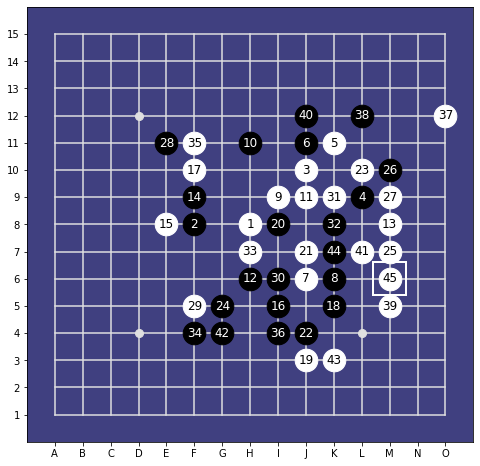

In [9]:
stones = coach.recover_moves(train_examples)
from domoku.board import GomokuBoard as LegacyBoard
board = LegacyBoard(n=15, disp_width=8, stones=[stone.xy() for stone in stones])
board.display()